In [1]:
!nvidia-smi

Sat Jul 10 03:04:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# %pip install -q --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110
# %pip install -q wandb

In [3]:
# from google.colab import files
# ret = files.upload()
# !mkdir  ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d jessicali9530/celeba-dataset

In [4]:
# !unzip -q celeba-dataset.zip
# !rm celeba-dataset.zip

# Import Libraries

In [5]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
from torch.cuda import amp

import os
import random
import numpy as np
from tqdm import tqdm
import PIL.Image as Image
from collections import OrderedDict
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

In [7]:
import wandb

In [31]:
config_defaults = {
    'BATCH_SIZE'        : 128,
    'noise_dim'         : 128,
    'input_size'        : 128,
    'dp_rate'           : 0.3,
    'gauss_std'         : 0.1,
    'nthreads'          : 2 * len(os.sched_getaffinity(0)),
    'max_lr'            : 2e-4,
    'betas'             : (0.5, 0.999),
    'seed'              : 614,
    'use_amp'           : True,
    'log_interval'      : 10,
    "z_notes"           : []
}
CONFIG = config_defaults

In [32]:
# #hide
# run = wandb.init(id='19sqz0by', project="facegan_pytorch", resume='must')
# CONFIG = run.config

In [33]:
run = wandb.init(project="facegan_pytorch", config=config_defaults)
CONFIG = wandb.config

Generator_loss,3.01151
Discriminator_loss,0.48309
_runtime,7285
_timestamp,1625893567
_step,4049


Generator_loss,█▂▁▂▂▂▁▁▁▂▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▃▄▄
Discriminator_loss,▅█▇▆▆▆▇█▆▅▇▅▅▅▅▆▂▄▆▂▃▃▅▄▃▃▅▂▃▁▃▁▃▃▃▁▂▇▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [34]:
def seed_everything(seed=33):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

seed_everything()

In [35]:
class AverageMeter:
    def __init__(self, name=None):
        self.name = name
        self.reset()

    def reset(self):
        self.val = self.sum = self.count = self.avg = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [36]:
from torchvision import transforms as T

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy

In [37]:
def get_preproc(input_size):
    return T.Compose([
        T.RandomResizedCrop(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.RandomHorizontalFlip(input_size),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])


def dali_pipeline(batch_size, num_threads, device_id, image_dir, input_size):
    pipe = Pipeline(batch_size, num_threads, device_id)
    with pipe:
        jpegs, lbls = fn.readers.file(file_root=image_dir, random_shuffle=True, name="Reader")
        images = fn.decoders.image(jpegs, device='mixed', output_type=types.RGB)
        images = fn.resize(images, device='gpu', resize_shorter=input_size, interp_type=types.INTERP_TRIANGULAR)
        mirror = fn.random.coin_flip(probability=0.5)
        images = fn.crop_mirror_normalize(images,
                                          dtype=types.FLOAT,
                                          output_layout="CHW",
                                          crop=(input_size, input_size),
                                          mean=[0.5 * 255, 0.5 * 255, 0.5 * 255],
                                          std=[0.5 * 255, 0.5 * 255, 0.5 * 255],
                                          mirror=mirror)
        pipe.set_outputs(images, lbls)
    return pipe

In [38]:
CONFIG['nthreads']

4

In [39]:
pipe = dali_pipeline(batch_size=CONFIG['BATCH_SIZE'], num_threads=CONFIG["nthreads"], device_id=0, image_dir="/content/img_align_celeba/", input_size=CONFIG["input_size"])
train_loader = DALIClassificationIterator(pipe, auto_reset=True, reader_name="Reader", last_batch_policy=LastBatchPolicy.PARTIAL)

In [40]:
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        return x + torch.empty_like(x).normal_(std=self.std)

In [41]:
class Generator(nn.Module):
    def __init__(self, noise_dim, activation=nn.ReLU, dp_rate=0.3):
        super().__init__()
        self.activation = activation
        self.stem = nn.Sequential(OrderedDict([
            ('linear',  nn.Linear(noise_dim, 512*4*4, bias=False)),
            ('bn',      nn.LazyBatchNorm1d()),
            ('act',     activation(inplace=True)),
            ('dropout', nn.Dropout(dp_rate)),       # try 2d for spatial
        ]))

        self.stacks = nn.Sequential(*[
            self.upsample(512, dp_rate=dp_rate),
            self.upsample(256, dp_rate=dp_rate),
            self.upsample(128, dp_rate=dp_rate),
            self.upsample(64, dp_rate=0)
        ])

        self.gen = nn.Sequential(OrderedDict([
            ('conv',    nn.LazyConvTranspose2d(3, kernel_size=4, stride=2, padding=1)),
            ('act',     nn.Tanh()),
        ]))

    def upsample(self, num_filters, bn=True, dp_rate=0.3):
        layers = [nn.LazyConvTranspose2d(num_filters, kernel_size=4, stride=2, bias=not bn, padding=1)]
        if bn:
            layers.append(nn.BatchNorm2d(num_filters))
        layers.append(self.activation(inplace=True))
        if dp_rate > 0:
            layers.append(nn.Dropout(dp_rate))      # try 2d for spatial
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = x.view(-1, 512, 4, 4)
        x = self.stacks(x)
        x = self.gen(x)
        return x

In [42]:
class Discriminator(nn.Module):
    def __init__(self, activation=nn.LeakyReLU, std=0.1):
        super().__init__()
        self.std = std
        self.activation = activation
        self.stacks = nn.Sequential(*[
            self.downsample(32, bn=False, stride=1),
            self.downsample(64),
            self.downsample(128),
            self.downsample(256),
            self.downsample(512)
        ])

        self.head = nn.Sequential(OrderedDict([
            ('gauss', GaussianNoise(self.std)),
            ('linear', nn.LazyLinear(1)),
            # ('act', nn.Sigmoid()),        # removed for BCEWithLogitsLoss
        ]))

    def downsample(self, num_filters, bn=True, stride=2):
        layers = [
            GaussianNoise(self.std),
            nn.LazyConv2d(num_filters, kernel_size=4, stride=stride, bias=not bn, padding=1)
        ]
        if bn:
            layers.append(nn.BatchNorm2d(num_filters))
        layers.append(self.activation(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stacks(x)
        x = x.flatten(1)
        x = self.head(x)
        return x

In [43]:
@torch.no_grad()
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [44]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
netG = Generator(CONFIG['noise_dim'], dp_rate=CONFIG['dp_rate']).to(DEVICE)
netD = Discriminator(std=CONFIG['gauss_std']).to(DEVICE)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [46]:
optG = torch.optim.Adam(netG.parameters(), lr=CONFIG['max_lr'], betas=CONFIG['betas'])
optD = torch.optim.Adam(netD.parameters(), lr=CONFIG['max_lr'], betas=CONFIG['betas'])

scaler = amp.GradScaler(enabled=CONFIG['use_amp'])

In [47]:
# def train_epoch(train_loader, netG, netD, optG, optD, scaler, noise_dim, epoch=1, use_amp=False, log_interval=10):
#     netG.train()
#     netD.train()
#     lossesG = AverageMeter()
#     lossesD = AverageMeter()
#     optG.zero_grad(set_to_none=True)
#     optD.zero_grad(set_to_none=True)
#     with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}") as pbar:
#         for idx, batch in pbar:
#             real_images = batch[0]['data']
#             noise = torch.randn(real_images.size(0), noise_dim, dtype=real_images.dtype,
#                                 device=real_images.device)
#             # Update generator
#             with amp.autocast(enabled=use_amp):
#                 fake_out = netD(netG(noise))
#                 lossG = criterion(fake_out, torch.ones_like(fake_out))  # Treat fake images as real to train the Generator.

#             netG.requires_grad_(True)           # Only calculate gradients for Generator.
#             netD.requires_grad_(False)          # Do not calculate gradients for Discriminator.
#             scaler.scale(lossG).backward(retain_graph=True) # retain graph cause fake_out is also used to calculate loss for Discriminator.
#             # Update the generator later.
            
#             lossesG.update(lossG.detach_(), noise.size(0))

#             # Update Discriminator
#             with amp.autocast(enabled=use_amp):
#                 real_out = netD(real_images)
#                 lossD = (criterion(real_out, torch.empty_like(real_out).uniform_(0.9, 1.0))
#                         + criterion(fake_out, torch.empty_like(fake_out).uniform_(0.0, 0.1)))   # Treat real as real and fake as fake to train Discriminator.

#             netG.requires_grad_(False)          # Do not calculate gradients for Generator.
#             netD.requires_grad_(True)           # Only calculate gradients for Discriminator.
#             scaler.scale(lossD).backward(retain_graph=True)
#             scaler.step(optD)
#             optD.zero_grad(set_to_none=True)

#             scaler.step(optG)
#             optG.zero_grad(set_to_none=True)

#             scaler.update()

#             lossesD.update(lossD.detach_(), real_images.size(0))
#             if not idx%log_interval:
#                 info = {'Generator_loss': float(lossesG.avg), 'Discriminator_loss': float(lossesD.avg)}
#                 wandb.log(info)
#                 pbar.set_postfix(info)

In [48]:
def set_grads(grads, params):
    for g,p in zip(grads, params):
        p.grad = g

def train_epoch(train_loader, netG, netD, optG, optD, scaler, noise_dim, epoch=1, use_amp=True, log_interval=10):
    netG.train()
    netD.train()
    lossesG = AverageMeter()
    lossesD = AverageMeter()
    optG.zero_grad(set_to_none=True)
    optD.zero_grad(set_to_none=True)
    with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch:>2}") as pbar:
        for idx, batch in pbar:
            real_images = batch[0]['data']
            noise = torch.randn(real_images.size(0), noise_dim, dtype=real_images.dtype,
                                device=real_images.device)
            with amp.autocast(enabled=use_amp):
                fake_out = netD(netG(noise))
                real_out = netD(real_images)
                lossG = criterion(fake_out, torch.ones_like(fake_out))                          # Treat fake images as real to train the Generator.
                lossD = (criterion(real_out, torch.empty_like(real_out).uniform_(0.9, 1.0))     # Treat real as real
                        + criterion(fake_out, torch.empty_like(fake_out).uniform_(0.0, 0.1)))   # and fake as fake to train Discriminator.

            scaled_gradsG = autograd.grad(scaler.scale(lossG), netG.parameters(), retain_graph=True)
            scaled_gradsD = autograd.grad(scaler.scale(lossD), netD.parameters())

            set_grads(scaled_gradsG, netG.parameters())
            set_grads(scaled_gradsD, netD.parameters())

            scaler.step(optD)
            optD.zero_grad(set_to_none=True)
            scaler.step(optG)
            optG.zero_grad(set_to_none=True)
            scaler.update()

            lossesG.update(lossG.detach_(), noise.size(0))
            lossesD.update(lossD.detach_(), real_images.size(0))
            if not idx%log_interval:
                info = {'Generator_loss': float(lossesG.avg), 'Discriminator_loss': float(lossesD.avg)}
                wandb.log(info)
                pbar.set_postfix(info)

In [49]:
@torch.no_grad()
def gen_grid(ncols=4, nrows=4, figsize=[16,16], show=True, wb_log=True):
    netG.eval()
    # netD.eval()
    noise = torch.randn(nrows*ncols, CONFIG['noise_dim'], dtype=torch.float32, device=DEVICE)
    gen = (netG(noise).detach_()+1)/2
    gen = gen.cpu().permute(0,2,3,1).numpy()       # convert to channel last
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw = {'wspace':0, 'hspace':0})
    fig.patch.set_facecolor('white')
    ims = []
    for i,axi in enumerate(ax.flat):
        axi.axis("off")
        axi.imshow(gen[i])
        if wb_log: ims.append(wandb.Image(gen[i]))
    if wb_log: wandb.log({"Generated": ims})
    if show:
        plt.show()
    else:
        plt.close(fig)
    # return gen

In [50]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [51]:
init_epoch = 1
NUM_EPOCHS = 50

In [52]:
#collapse-output
for epoch in range(init_epoch, NUM_EPOCHS+1):
    train_loss = train_epoch(train_loader,
                             netG = netG,
                             netD = netD,
                             optG = optG,
                             optD = optD,
                             scaler = scaler,
                             noise_dim = CONFIG['noise_dim'],
                             epoch=epoch,
                             use_amp=CONFIG['use_amp'],
                             log_interval=CONFIG['log_interval'])
    
    gen_grid(ncols=4, nrows=2, figsize=[16, 8], show=False)
    gc.collect()
    # if not epoch%10:
    #     save_model(model, optimizer, epoch)

Epoch  50: 100%|██████████| 1583/1583 [02:28<00:00, 10.69it/s, Generator_loss=2.97, Discriminator_loss=0.536]


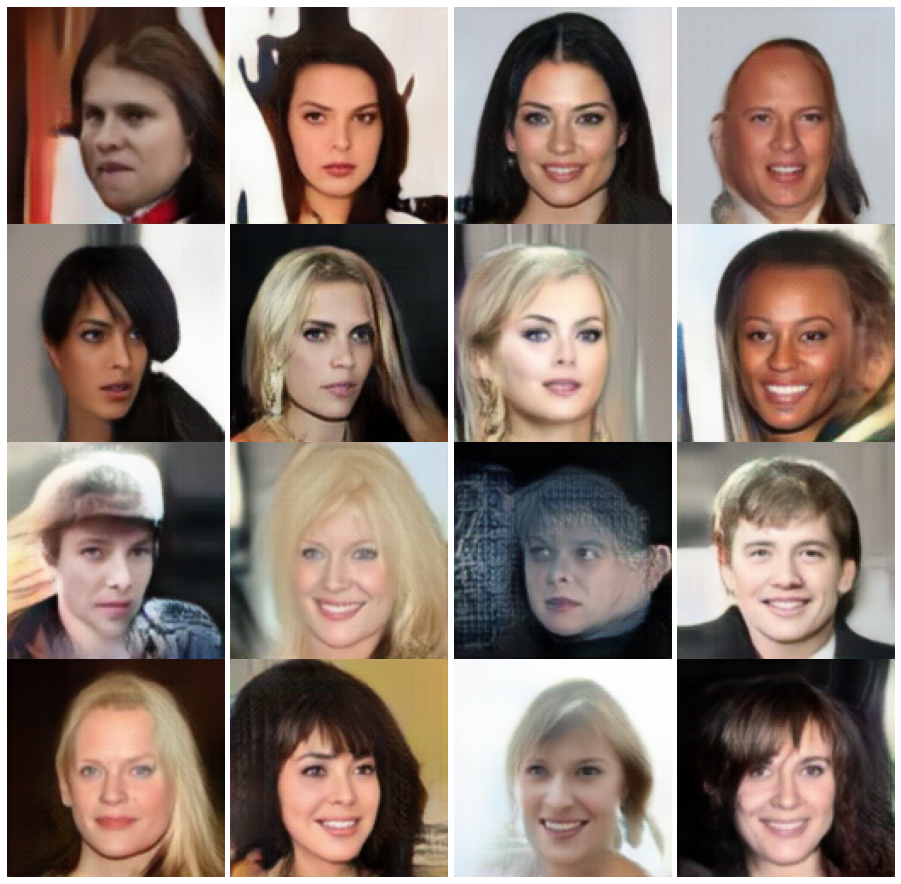

In [53]:
_ = gen_grid(wb_log=False)  # newer

In [30]:
run.finish()